In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_squared_log_error
import xgboost as xgb

In [2]:
# Random seed for reproducibility
RANDOM_STATE = 21
np.random.seed(RANDOM_STATE)

# Load Data
print("Loading data...")
try:
    df_train_full = pd.read_csv("train.csv")
    df_test_full = pd.read_csv("test.csv")
except FileNotFoundError:
    print("Ensure 'train.csv' and 'test.csv' are in the same directory as the script.")

Loading data...


In [3]:
# Basic Preprocessing to get data into usable format
print("Performing basic preprocessing...")

# Training data
df_train_processed = df_train_full.copy()
le_sex = LabelEncoder()
df_train_processed['Sex'] = le_sex.fit_transform(df_train_processed['Sex'])

# Test data
df_test_processed = df_test_full.copy()
df_test_processed['Sex'] = le_sex.transform(df_test_processed['Sex'])

Performing basic preprocessing...


Analyzing target variable 'Calories'...
Skewness of Calories: 0.539196264522959


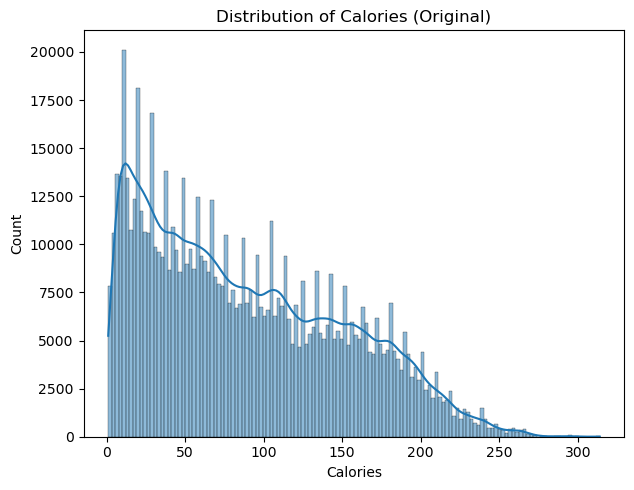

In [ ]:
# Analyse target variable
print("Analyzing target variable 'Calories'...")
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(df_train_processed['Calories'], kde=True)
plt.title('Distribution of Calories (Original)')

# Check skewness
skewness = df_train_processed['Calories'].skew()
print(f"Skewness of Calories: {skewness}")

TARGET_TRANSFORMED = False

if skewness > 0.75: # If excessively skew then transform
    print("Target variable is skewed. Applying log1p transformation.")
    df_train_processed['Calories'] = np.log1p(df_train_processed['Calories'])
    TARGET_TRANSFORMED = True
    plt.subplot(1, 2, 2)
    sns.histplot(df_train_processed['Calories'], kde=True)
    plt.title('Distribution of Calories (Log1p Transformed), transformed={}'.format(TARGET_TRANSFORMED))
plt.tight_layout()
plt.show()

In [ ]:
# Define training features (X) and target (Y)
print("Defining features and target...")
X = df_train_processed.drop(["Calories", "id"], axis=1)
Y = df_train_processed["Calories"]
feature_names = X.columns.tolist()

# Define test set
X_test_final = df_test_processed.drop("id", axis=1, errors='ignore')

Defining features and target...


In [ ]:
# Train / Test / Split
print("Splitting data for validation...")
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=RANDOM_STATE)

Splitting data for validation...


In [ ]:
# Feature scaling
print("Scaling features...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test_final)

# Convert back to DataFrame to keep column names
X_train_scaled = pd.DataFrame(X_train_scaled, columns=feature_names)
X_val_scaled = pd.DataFrame(X_val_scaled, columns=feature_names)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=feature_names)

Scaling features...


In [8]:
#xgb_model = xgb.XGBRegressor(n_estimators=300, learning_rate=0.1, max_depth=3, subsample=0.7, colsample_bytree=0.7)
#best_xgb_model = xgb_model.fit(X_train_scaled, Y_train)

In [ ]:
# XGBoost Model Training & Tuning

# Alternative objective (competition performance measure)
#def msle(y_true, y_pred):
#    y_pred = np.clip(y_pred, -1+1e-6, None) # make sure y_pred > -1
#    g = (np.log1p(y_pred)-np.log1p(y_true)) / (y_pred+1)
#    h = (1-np.log1p(y_pred)+np.log1p(y_true)) / (y_pred+1)**2
#    h = np.maximum(h, 1 / (y_pred+1)**2) # majorant
#    return g, h


print("Setting up XGBoost model and GridSearchCV...")
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=RANDOM_STATE, n_jobs=-1)
#xgb_model = xgb.XGBRegressor(objective=msle, random_state=RANDOM_STATE, n_jobs=-1)

# Define grid for tuning
param_grid_xgb = {
    'n_estimators': [300, 400],
    'learning_rate': [0.01, 0.05],
    'max_depth': [5, 7, 9],
    'subsample': [0.8, 1.0, 1.2],
    'colsample_bytree': [0.8],
    'reg_alpha' : [0.0, 1.0],
    'reg_lambda' : [0.0, 1.0]
}

grid_search_xgb = GridSearchCV(estimator=xgb_model,
                               param_grid=param_grid_xgb,
                               scoring='neg_mean_squared_error',
                               cv=3,
                               verbose=1,
                               n_jobs=-1) # Use all available cores

print("Starting GridSearchCV for XGBoost...")
grid_search_xgb.fit(X_train_scaled, Y_train)

print("Best parameters found by GridSearchCV:")
print(grid_search_xgb.best_params_)

best_xgb_model = grid_search_xgb.best_estimator_

Setting up XGBoost model and GridSearchCV...
Starting GridSearchCV for XGBoost...
Fitting 3 folds for each of 243 candidates, totalling 729 fits
Best parameters found by GridSearchCV:
{'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 300, 'subsample': 1.0}


In [ ]:
# Evaluate trained model on validation set
print("Evaluating the best XGBoost model...")
y_pred_val_xgb = best_xgb_model.predict(X_val_scaled)

#### IGNORE & REMOVE #### Inverse transform predictions and Y_val if target was transformed
if TARGET_TRANSFORMED:
    y_pred_val_xgb_orig_scale = np.expm1(y_pred_val_xgb)
    Y_val_orig_scale = np.expm1(Y_val)
else:
    y_pred_val_xgb_orig_scale = y_pred_val_xgb
    Y_val_orig_scale = Y_val

# Ensure non-negative predictions for input to RMSLE calc
y_pred_val_xgb_orig_scale_non_neg = np.maximum(0, y_pred_val_xgb_orig_scale)
Y_val_orig_scale_non_neg = np.maximum(0, Y_val_orig_scale)

val_mse_xgb = mean_squared_error(Y_val_orig_scale, y_pred_val_xgb_orig_scale)
val_rmse_xgb = np.sqrt(val_mse_xgb)
val_r2_xgb = r2_score(Y_val_orig_scale, y_pred_val_xgb_orig_scale)

try:
    val_rmsle_xgb = np.sqrt(mean_squared_log_error(Y_val_orig_scale_non_neg, y_pred_val_xgb_orig_scale_non_neg))
except ValueError as e:
    print(f"Error calculating RMSLE: {e}. This might happen if there are still negative values after transformation.")
    val_rmsle_xgb = np.nan


print(f"\nXGBoost Validation Metrics (Original Scale):")
print(f"Validation MSE: {val_mse_xgb:.4f}")
print(f"Validation RMSE: {val_rmse_xgb:.4f}")
print(f"Validation R2 Score: {val_r2_xgb:.4f}")
print(f"Validation RMSLE: {val_rmsle_xgb:.4f}")

Evaluating the best XGBoost model...

XGBoost Validation Metrics (Original Scale):
Validation MSE: 13.0203
Validation RMSE: 3.6084
Validation R2 Score: 0.9967
Validation RMSLE: 0.0613


In [ ]:
# Generate predictions based on test set
print("\nMaking predictions on the test set...")
y_pred_test_xgb = best_xgb_model.predict(X_test_scaled)

### IGNORE & REMOVE ### Inverse transform test predictions if target was transformed
if TARGET_TRANSFORMED:
    y_pred_test_xgb_orig_scale = np.expm1(y_pred_test_xgb)
else:
    y_pred_test_xgb_orig_scale = y_pred_test_xgb

# Ensure predictions are non-negative
final_test_predictions = np.maximum(0, y_pred_test_xgb_orig_scale)


Making predictions on the test set...


In [ ]:
# Create submission file
print("Creating submission file...")
submission_xgb = pd.DataFrame({
    'id': df_test_full['id'],
    'Calories': final_test_predictions
})

submission_filename = 'xgbv1_submission_2.csv'
submission_xgb.to_csv(submission_filename, index=False)
print(f"✅ Submission file '{submission_filename}' created successfully!")

Creating submission file...
✅ Submission file 'xgbv1_submission_2.csv' created successfully!
